In [1]:
from astromodule.io import read_table, write_table
from astromodule.table import concat_tables, fast_crossmatch, crossmatch, selfmatch, drop_duplicates
from astromodule.distance import mpc2arcsec
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import pandas as pd
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from astropy.wcs import WCS
from mw_plot import MWSkyMap

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

[4342.35606838 4342.3697338  4343.74403787 ... 4353.96506111 4353.15682219
 4353.08523913] deg
0        -52.492166
1        -52.491565
2        -52.491189
3        -52.492688
4        -52.492668
            ...    
741740   -55.064265
741741   -55.216379
741742   -55.213438
741743   -55.063481
741744   -55.063866
Name: dec, Length: 741745, dtype: float64


Text(0.5, 1.0, '4.5814431223004055 deg')

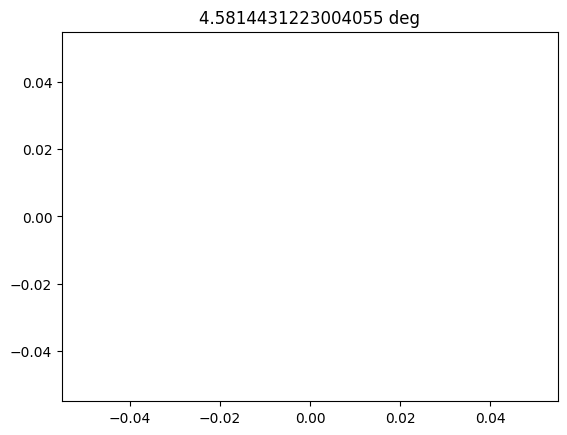

In [17]:
def haversine(ra1, dec1, ra2, dec2):
  ra1, dec1, ra2, dec2 = map(np.radians, [ra1, dec1, ra2, dec2])
  delt_lon = (ra1 - ra2)
  delt_lat = (dec1 - dec2)
  dist = 2.0 * np.arcsin(np.sqrt(
    np.sin(delt_lat/2.0)**2 + 
    np.cos(dec1)*np.cos(dec2)*np.sin(delt_lon/2.0)**2
  ))  
  return np.degrees(dist)

def arclen(ra1, dec1, ra2, dec2):
  cos_gamma = np.cos(np.pi - dec1)*np.cos(np.pi-dec2) + np.sin(np.pi-dec1)*np.sin(np.pi-dec2)*np.cos(ra1-ra2)
  gamma = np.arccos(cos_gamma)
  return gamma * u.rad


def arclen2(ra1, dec1, ra2, dec2):
  a = (ra1-ra2)*np.cos((dec1+dec2)/2)
  b = dec1-dec2
  return np.sqrt(a**2 + b**2) * u.rad


df = read_table('outputs_v6/photo/1eRASS J034011.5-550329.parquet')
ra = 55.06340
dec = -55.20178
z = 0.0447
search_radius = mpc2arcsec(15, z).to('deg')
ra_vec = (df.ra.values * u.deg).to(u.rad).value
dec_vec = (df.dec.values * u.deg).to(u.rad).value
sep = arclen2(ra_vec, dec_vec, ra, dec)
mask = sep < search_radius
print(sep.to(u.deg))
df2 = df[mask]
plt.scatter(df2.ra, df2.dec)
plt.title(search_radius)

In [ ]:
df = read_table('/mnt/hd/natanael/astrodata/splus_idr5_2024-04-20_restricted_csfd.csv')
del df['ID']
del df['PHOT_ID_dual_1']
del df['PHOT_ID_dual_2']
del df['PHOT_ID_dual_3']
del df['PHOT_ID_dual_4']
del df['PHOT_ID_dual_5']
del df['PHOT_ID_dual_6']
del df['PHOT_ID_dual_7']
del df['PHOT_ID_dual_8']
del df['PHOT_ID_dual_9']
del df['PHOT_ID_dual_10']
del df['PHOT_ID_dual_11']
del df['PHOT_ID_dual_12']
write_table(df, '/mnt/hd/natanael/astrodata/splus_idr5_2024-04-20_restricted_csfd.parquet')
del df

In [2]:
df_legacy = concat_tables(list(Path('outputs_v6/legacy').glob('*')))
df_mag = read_table('/mnt/hd/natanael/astrodata/splus_idr5_2024-04-20_restricted_csfd.parquet')
df_match = fast_crossmatch(df_mag, df_legacy)
write_table(df_match, '/mnt/hd/natanael/astrodata/splus_idr5_2024-04-20_restricted_csfd_match.parquet')
# df_match = read_table('/mnt/hd/natanael/astrodata/splus_idr5_2024-04-20_restricted_csfd_match.parquet')

In [2]:
df_ext = read_table('/mnt/hd/natanael/astrodata/external_catalog.parquet')

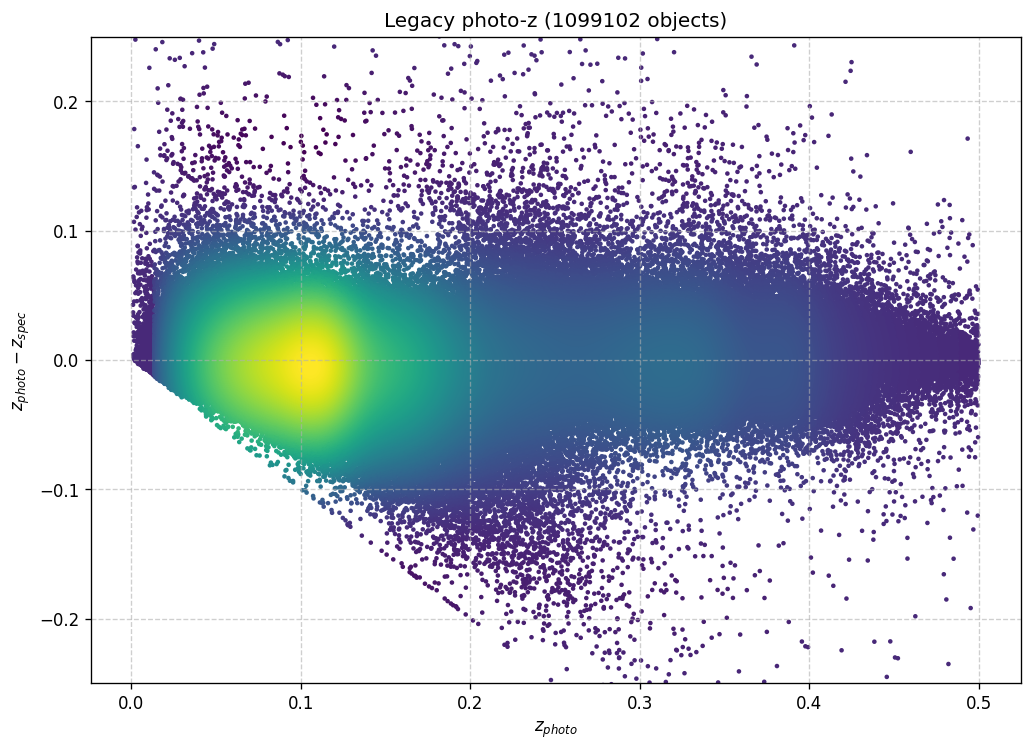

In [10]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs ):
  """
  Scatter plot colored by 2d histogram
  """
  if ax is None :
      fig , ax = plt.subplots()
  data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
  z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

  #To be sure to plot all data
  z[np.where(np.isnan(z))] = 0.0

  # Sort the points by density, so that the densest points are plotted last
  if sort :
      idx = z.argsort()
      x, y, z = x[idx], y[idx], z[idx]

  ax.scatter( x, y, c=z, s=3, **kwargs )
  
fig, ax = plt.subplots(
  1, 1,
  figsize=(10, 7),
  dpi=120
)
df = df_ext[(~df_ext.photo_z.isna()) & (~df_ext.spec_z.isna())]
density_scatter(df.photo_z.values, (df.spec_z - df.photo_z).values, ax=ax)
ax.grid(linestyle='--', alpha=0.6)
ax.set_ylim(-0.25, 0.25)
ax.set_title(f'Legacy photo-z ({len(df)} objects)')
ax.set_ylabel('$z_{{photo}} - z_{{spec}}$')
ax.set_xlabel('$z_{{photo}}$')
plt.show()

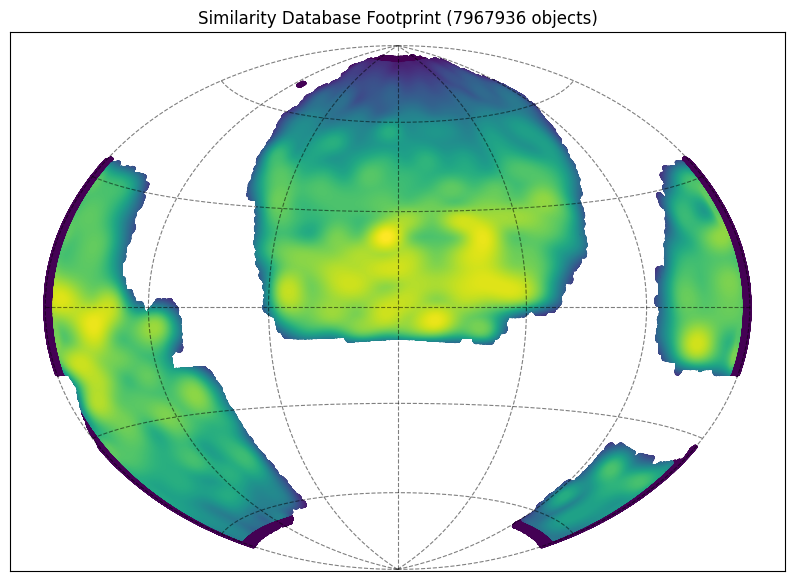

In [10]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs ):
  """
  Scatter plot colored by 2d histogram
  """
  if ax is None :
      fig , ax = plt.subplots()
  data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
  z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

  #To be sure to plot all data
  z[np.where(np.isnan(z))] = 0.0

  # Sort the points by density, so that the densest points are plotted last
  if sort :
      idx = z.argsort()
      x, y, z = x[idx], y[idx], z[idx]
      
  # mw = MWSkyMap(projection='equirectangular', center=(180, 0)*u.deg, radius=(0, 90)*u.deg, grayscale=False, grid=True)
  # mw.mw_scatter(x*u.deg, y*u.deg, z)
  # return mw.ax

  ax.scatter( x, y, c=z, s=3, **kwargs )


df_similarity = read_table('/mnt/hd/natanael/astrodata/representations_pca_40_with_coords.parquet', columns=['ra', 'dec'])


wcs_spec =  {
  # 'CDELT1': -1.0,
  # 'CDELT2': 1.0,
  # 'CRPIX1': 8.5,
  # 'CRPIX2': 8.5,
  'CRVAL1': 180,
  'CRVAL2': 0,
  'CTYPE1': 'RA---AIT',
  'CTYPE2': 'DEC--AIT',
  'CUNIT1': 'deg',
  'CUNIT2': 'deg'
}
wcs = WCS(wcs_spec)
fig = fig = plt.figure(figsize=(10, 7), dpi=100)
ax = fig.add_subplot(projection=wcs)
# ax.scatter(df_similarity.ra.values, df_similarity.dec.values, transform=ax.get_transform('icrs'))
density_scatter(df_similarity.ra.values, df_similarity.dec.values, ax=ax, transform=ax.get_transform('icrs'), bins=30)
# ax = density_scatter(df_similarity.ra.values[:100_000], df_similarity.dec.values[:100_000], bins=100)
ax.grid('on', color='k', linestyle='--', alpha=.5)
ax.tick_params(direction='in')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'Similarity Database Footprint ({len(df_similarity)} objects)')
plt.show()

In [2]:
df_similarity = read_table('/mnt/hd/natanael/astrodata/representations_pca_40_with_coords.parquet', columns=['ra', 'dec'])

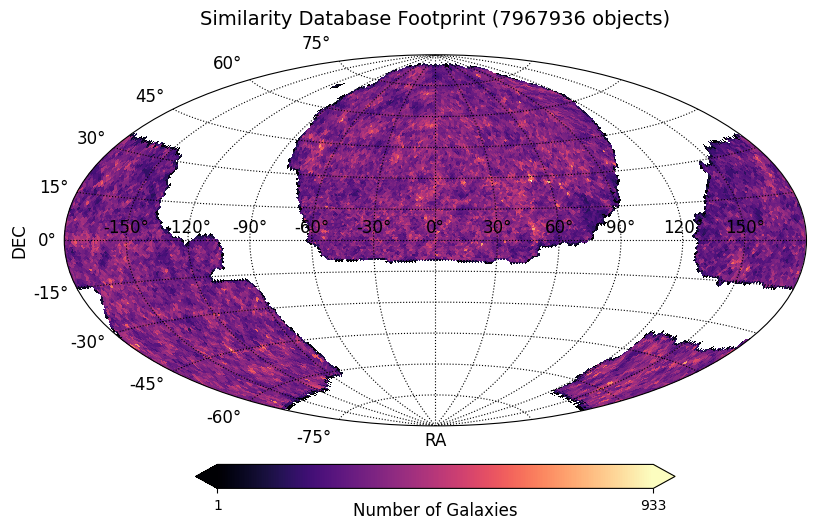

In [195]:
from astropy.coordinates import SkyCoord
import healpy as hp
import numpy as np

def cat2hpx(lon, lat, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates

    """

    npix = hp.nside2npix(nside)

    # if radec:
    #     eq = SkyCoord(lon, lat, frame='icrs', unit='deg')
    #     l, b = eq.galactic.l.value, eq.galactic.b.value
    # else:
    #     l, b = lon, lat

    # # # conver to theta, phi
    # theta = np.radians(90. - b)
    # phi = np.radians(l)

    # convert to HEALPix indices
    # indices = hp.ang2pix(nside, theta, phi)
    indices = hp.ang2pix(nside, lon, lat, lonlat=True)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map
  

m = cat2hpx(df_similarity.ra.values, df_similarity.dec.values, nside=64, radec=True)
# hp.mollview(hp.ma(m, 0), title=f'Similarity Database Footprint ({len(df_similarity)} objects)', rot=(180, 0), cmap=cm, badcolor='white', bgcolor='white', alpha=alpha)
# hp.graticule()
hp.projview(
  hp.ma(m, 0),
  cmap='magma',
  coord="C",
  graticule=True,
  graticule_labels=True,
  unit="Number of Galaxies",
  xlabel="RA",
  ylabel="DEC",
  cb_orientation="horizontal",
  projection_type="aitoff",
  rot=(180, 0),
  flip='geo',
  # norm='hist',
  # xtick_label_color='wite',
  graticule_color='k',
  title=f'Similarity Database Footprint ({len(df_similarity)} objects)\n',
  extend='both',
  longitude_grid_spacing=30,
  latitude_grid_spacing=15,
  phi_convention='symmetrical',
  override_plot_properties={'cbar_pad': 0.08},
)

# b, l = np.full(100, 0), np.linspace(0, 360, 100)
# c = SkyCoord(l, b, frame='galactic', unit='deg')
# l, b = c.icrs.ra.value, c.icrs.dec.value
# theta, phi = np.radians(90 - b), np.radians(l)
# plt.gca().plot(phi, theta, c='k')
# hp.newprojplot(theta, phi, c='k')

plt.gca().collections[0].cmap.set_bad('white')
plt.gca().grid(which='both', linestyle=':')
plt.show()

array([[<Axes: title={'center': 'est_petro_th50_kpc'}>]], dtype=object)

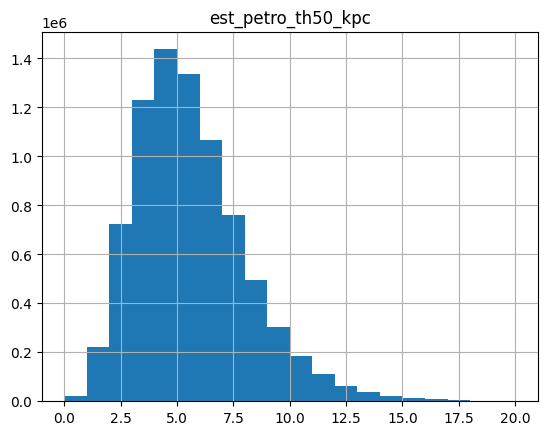

In [21]:
df_ext.hist('est_petro_th50_kpc', bins=20, range=(0, 20))

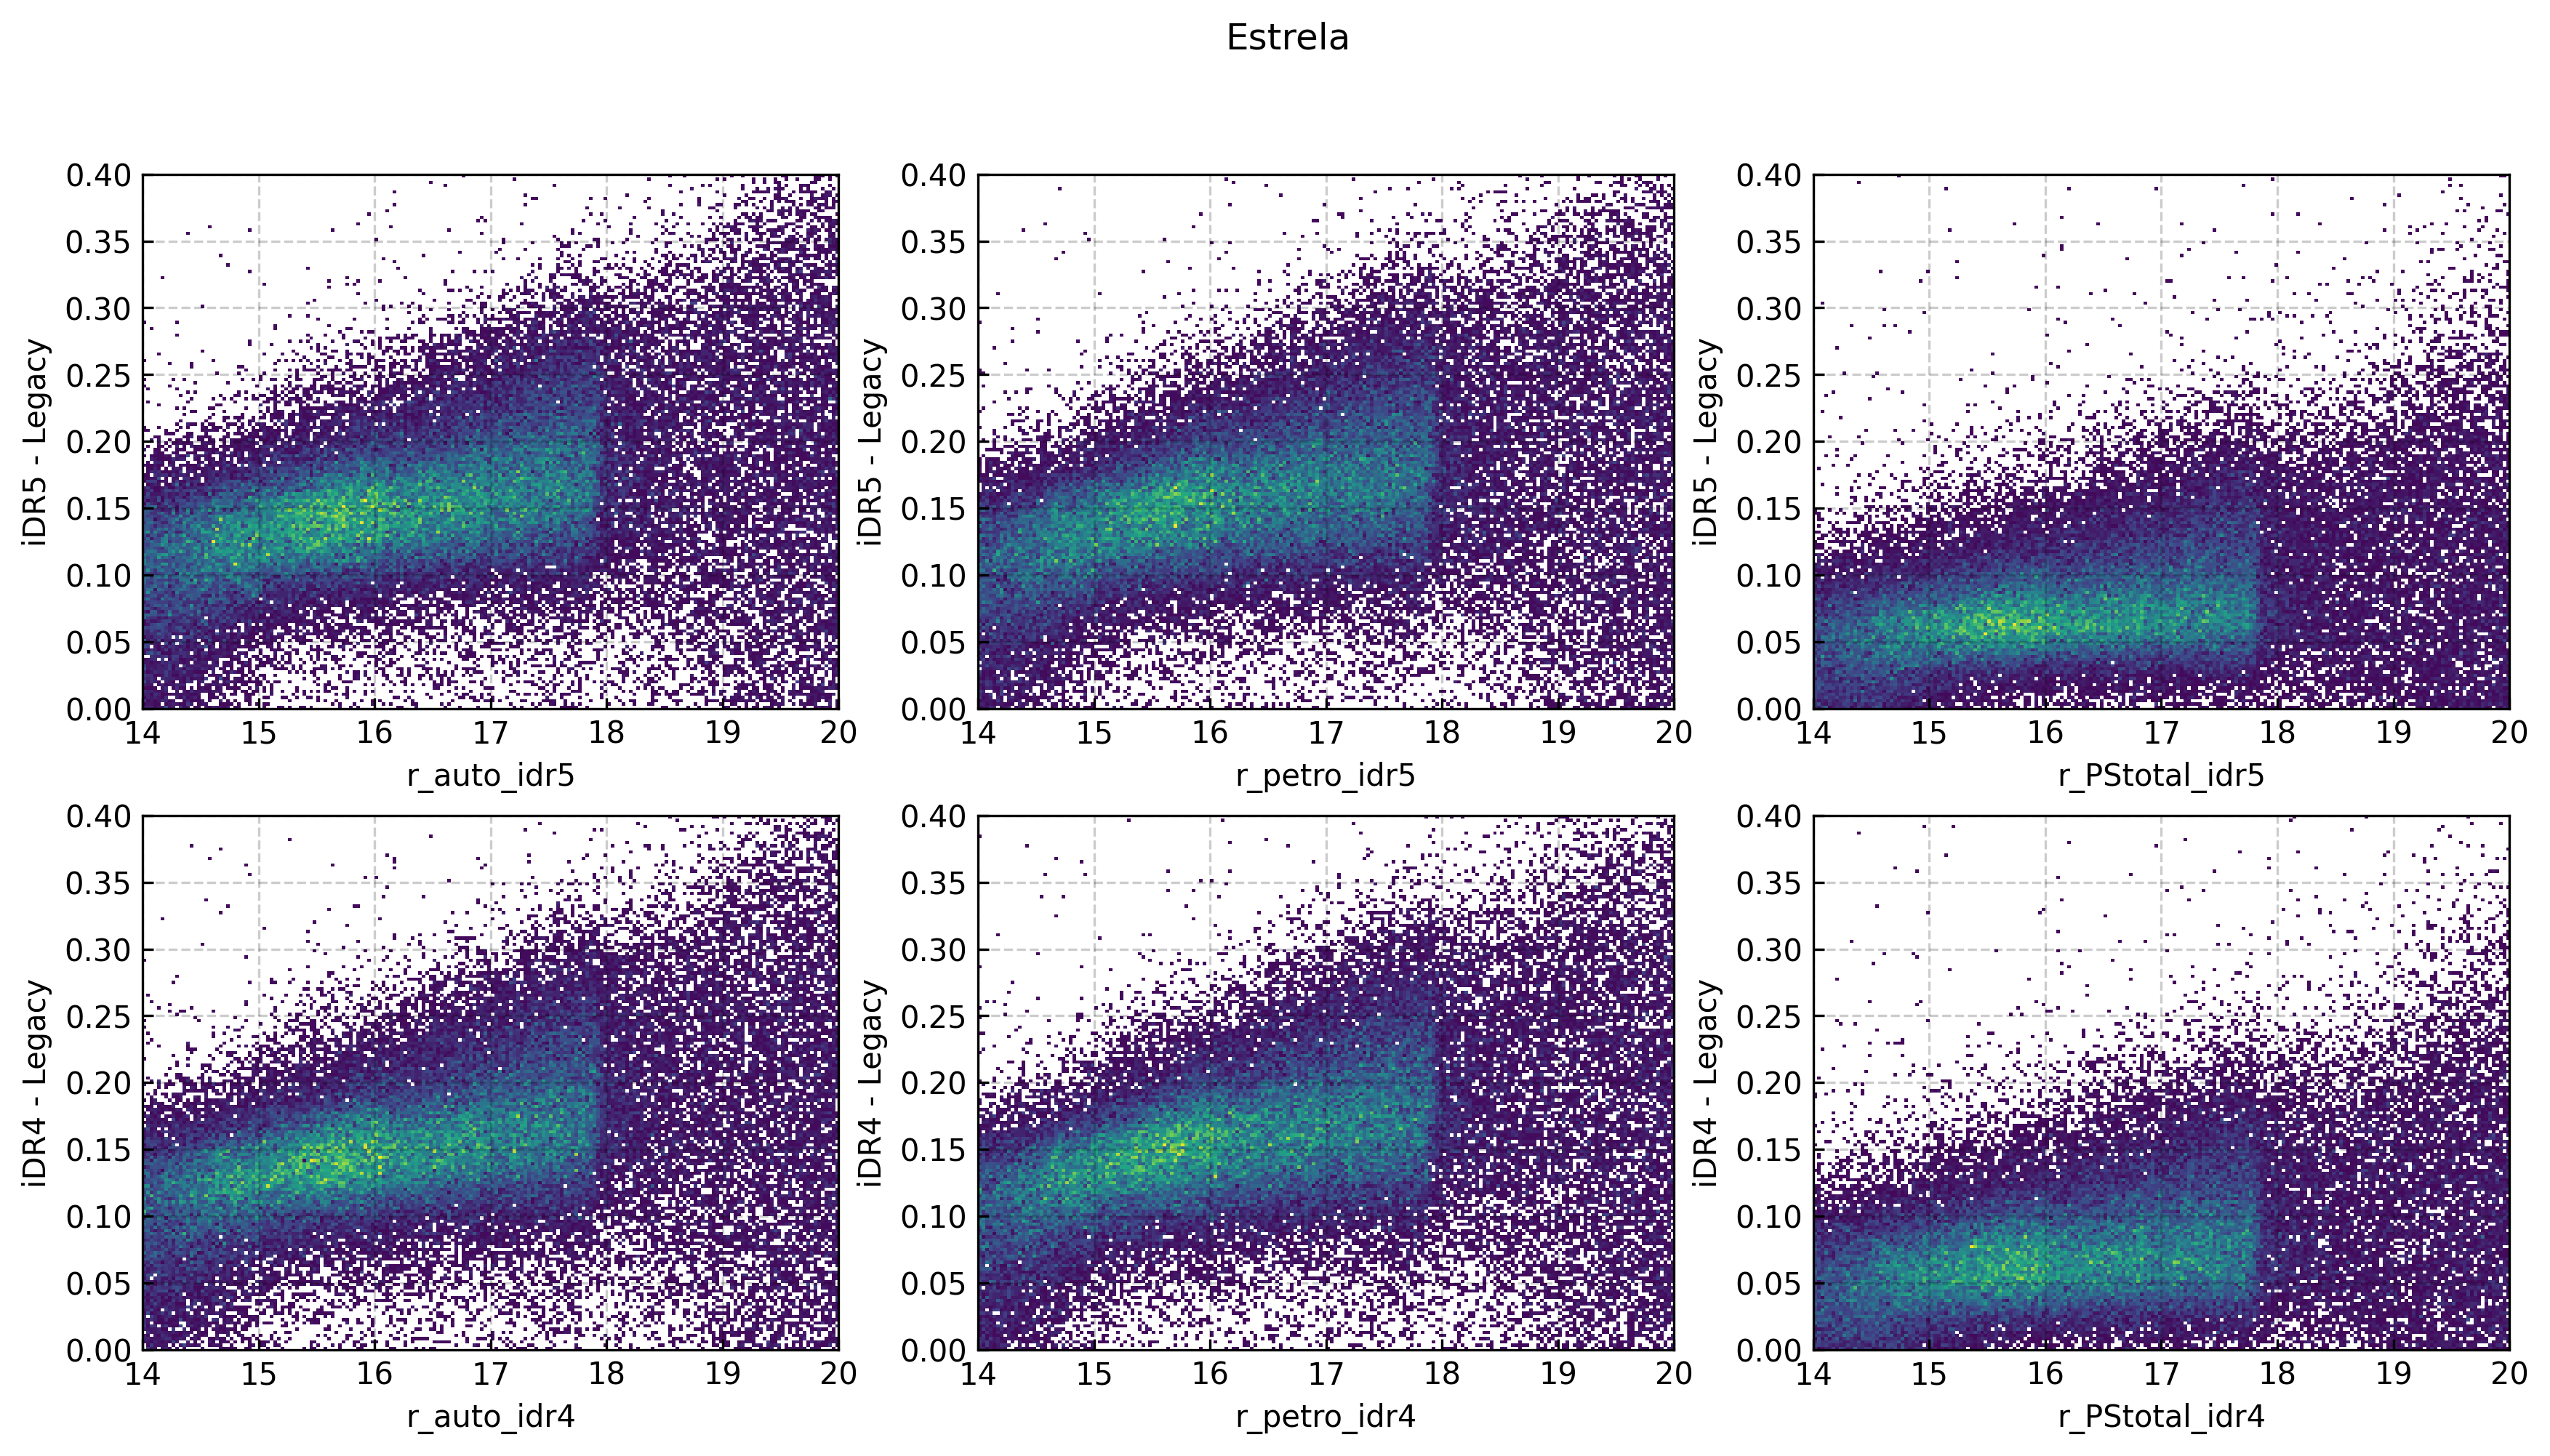

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs ):
  """
  Scatter plot colored by 2d histogram
  """
  if ax is None :
      fig , ax = plt.subplots()
  data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
  z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

  #To be sure to plot all data
  z[np.where(np.isnan(z))] = 0.0

  # Sort the points by density, so that the densest points are plotted last
  if sort :
      idx = z.argsort()
      x, y, z = x[idx], y[idx], z[idx]

  ax.scatter( x, y, c=z, s=3, **kwargs )


def plot_mag_diff(df: pd.DataFrame, splus_mag: str, leg_mag: str, ax: plt.Axes, ylabel=None):
  df_clean = df[df[splus_mag].between(13, 22)]
  y = df_clean[splus_mag] - df_clean[leg_mag]
  x = df_clean[splus_mag]
  density = ax.scatter_density(x, y, cmap=white_viridis)
  # density_scatter(x=x.values, y=y.values, ax=ax)
  ax.set_xlabel(splus_mag)
  ax.set_ylabel(ylabel)
  ax.set_ylim(0, .4)
  ax.set_xlim(14,20)
  ax.grid('on', color='k', linestyle='--', alpha=.2)
  ax.tick_params(direction='in')

white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
fig, axs = plt.subplots(
  nrows=2, 
  ncols=3, 
  figsize=(14, 7), 
  subplot_kw={'projection': 'scatter_density'}, 
  dpi=300
)
df = df_match[df_match.type == 'PSF']
plot_mag_diff(df, 'r_auto_idr5', 'mag_r', axs[0,0], ylabel='iDR5 - Legacy')
plot_mag_diff(df, 'r_petro_idr5', 'mag_r', axs[0,1], ylabel='iDR5 - Legacy')
plot_mag_diff(df, 'r_PStotal_idr5', 'mag_r', axs[0,2], ylabel='iDR5 - Legacy')
plot_mag_diff(df, 'r_auto_idr4', 'mag_r', axs[1,0], ylabel='iDR4 - Legacy')
plot_mag_diff(df, 'r_petro_idr4', 'mag_r', axs[1,1], ylabel='iDR4 - Legacy')
plot_mag_diff(df, 'r_PStotal_idr4', 'mag_r', axs[1,2], ylabel='iDR4 - Legacy')
# fig.colorbar(density)
plt.suptitle('Estrela')
plt.show()


# fig, axs = plt.subplots(
#   nrows=2, 
#   ncols=3, 
#   figsize=(14, 7), 
#   subplot_kw={'projection': 'scatter_density'}, 
#   dpi=300
# )
# df = df_match[df_match.type != 'PSF']
# plot_mag_diff(df, 'r_auto_idr5', 'mag_r', axs[0,0], ylabel='iDR5 - Legacy')
# plot_mag_diff(df, 'r_petro_idr5', 'mag_r', axs[0,1], ylabel='iDR5 - Legacy')
# plot_mag_diff(df, 'r_PStotal_idr5', 'mag_r', axs[0,2], ylabel='iDR5 - Legacy')
# plot_mag_diff(df, 'r_auto_idr4', 'mag_r', axs[1,0], ylabel='iDR4 - Legacy')
# plot_mag_diff(df, 'r_petro_idr4', 'mag_r', axs[1,1], ylabel='iDR4 - Legacy')
# plot_mag_diff(df, 'r_PStotal_idr4', 'mag_r', axs[1,2], ylabel='iDR4 - Legacy')
# # fig.colorbar(density)
# plt.suptitle('Galaxia')
# plt.show()


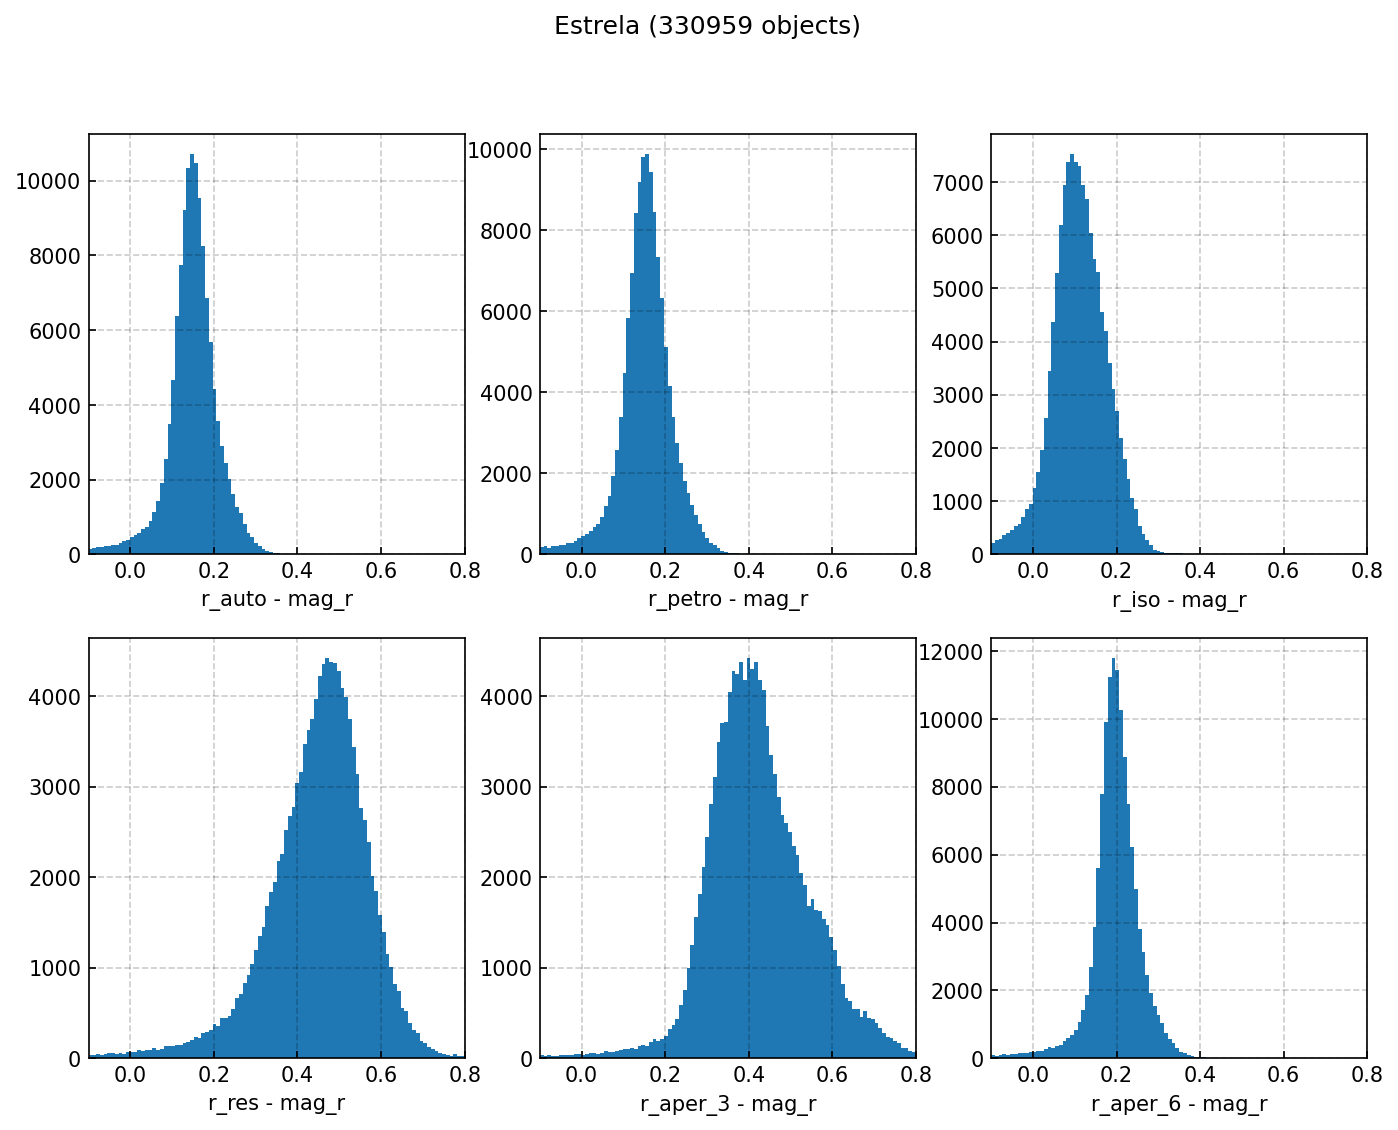

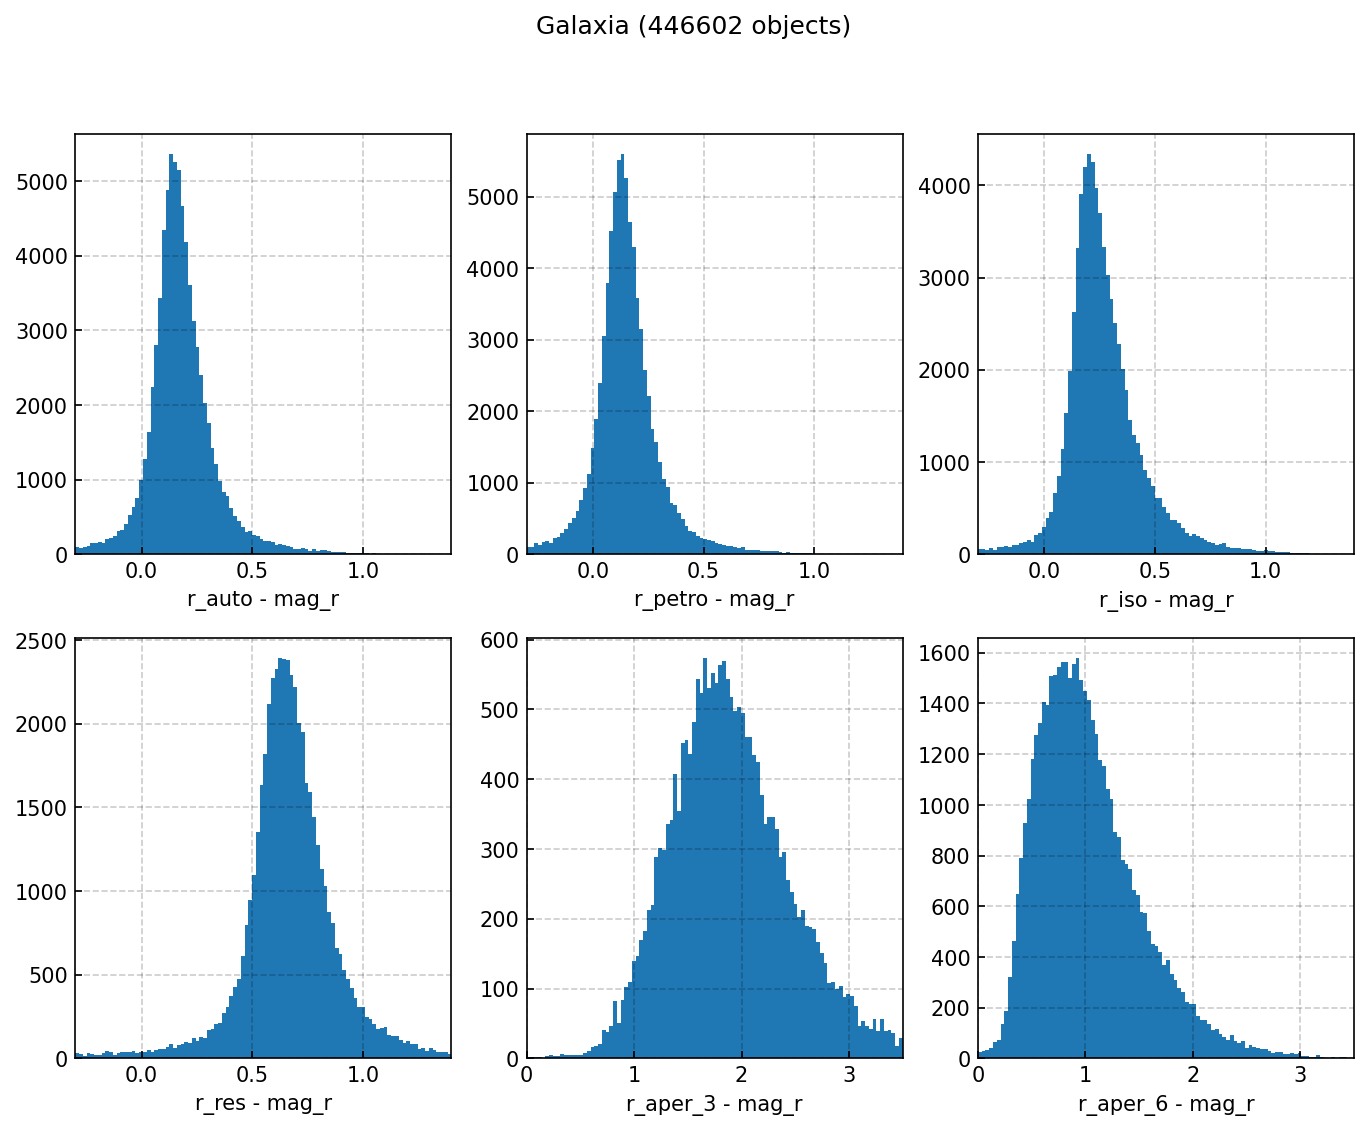

In [11]:
from typing import Tuple


def plot_hist(
  df: pd.DataFrame, 
  splus_mag: str, 
  leg_mag: str, 
  ax: plt.Axes, 
  xrange: Tuple[float, float] = (-.5, .5), 
  ylabel: str = None
):
  df_clean = df[df[splus_mag].between(14, 18)]
  ax.hist(df_clean[splus_mag] - df_clean[leg_mag], bins=100, range=xrange)
  ax.set_xlabel(f'{splus_mag} - {leg_mag}')
  ax.set_xlim(*xrange)
  ax.grid('on', color='k', linestyle='--', alpha=.2)
  ax.tick_params(direction='in')
  
fig, axs = plt.subplots(
  nrows=2, 
  ncols=3, 
  figsize=(11,8),
  dpi=150
)
df = df_match[df_match.type == 'PSF']
# plot_hist(df, 'r_auto_idr5', 'mag_r', axs[0,0], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_petro_idr5', 'mag_r', axs[0,1], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_iso_idr5', 'mag_r', axs[0,2], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_auto_idr4', 'mag_r', axs[1,0], ylabel='iDR4 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_petro_idr4', 'mag_r', axs[1,1], ylabel='iDR4 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_iso_idr4', 'mag_r', axs[1,2], ylabel='iDR4 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_restricted_auto_idr5', 'mag_r', axs[2,0], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_aper_3_idr5', 'mag_r', axs[2,1], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_aper_6_idr5', 'mag_r', axs[2,2], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_res_idr4', 'mag_r', axs[3,0], ylabel='iDR4 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_aper_3_idr4', 'mag_r', axs[3,1], ylabel='iDR4 - Legacy', xrange=(-0.1, 0.8))
# plot_hist(df, 'r_aper_6_idr4', 'mag_r', axs[3,2], ylabel='iDR4 - Legacy', xrange=(-0.1, 0.8))
plot_hist(df, 'r_auto', 'mag_r', axs[0,0], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
plot_hist(df, 'r_petro', 'mag_r', axs[0,1], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
plot_hist(df, 'r_iso', 'mag_r', axs[0,2], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
plot_hist(df, 'r_res', 'mag_r', axs[1,0], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
plot_hist(df, 'r_aper_3', 'mag_r', axs[1,1], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
plot_hist(df, 'r_aper_6', 'mag_r', axs[1,2], ylabel='iDR5 - Legacy', xrange=(-0.1, 0.8))
plt.suptitle(f'Estrela ({len(df)} objects)')
plt.show()

fig, axs = plt.subplots(
  nrows=2, 
  ncols=3, 
  figsize=(11,8),
  dpi=150
)
df = df_match[df_match.type != 'PSF']
# plot_hist(df, 'r_auto_idr5', 'mag_r', axs[0,0], ylabel='iDR5 - Legacy', xrange=(-0.4, 0.8))
# plot_hist(df, 'r_petro_idr5', 'mag_r', axs[0,1], ylabel='iDR5 - Legacy', xrange=(-0.4, 0.8))
# plot_hist(df, 'r_PStotal_idr5', 'mag_r', axs[0,2], ylabel='iDR5 - Legacy', xrange=(0, 3.5))
# plot_hist(df, 'r_auto_idr4', 'mag_r', axs[1,0], ylabel='iDR4 - Legacy', xrange=(-0.4, 0.8))
# plot_hist(df, 'r_petro_idr4', 'mag_r', axs[1,1], ylabel='iDR4 - Legacy', xrange=(-0.4, 0.8))
# plot_hist(df, 'r_PStotal_idr4', 'mag_r', axs[1,2], ylabel='iDR4 - Legacy', xrange=(0, 3.5))
# plot_hist(df, 'r_iso_idr5', 'mag_r', axs[2,0], ylabel='iDR5 - Legacy', xrange=(-0.4, 0.8))
# plot_hist(df, 'r_aper_3_idr5', 'mag_r', axs[2,1], ylabel='iDR5 - Legacy', xrange=(0, 3.5))
# plot_hist(df, 'r_aper_6_idr5', 'mag_r', axs[2,2], ylabel='iDR5 - Legacy', xrange=(0, 3.5))
# plot_hist(df, 'r_iso_idr4', 'mag_r', axs[3,0], ylabel='iDR4 - Legacy', xrange=(-0.4, 0.8))
# plot_hist(df, 'r_aper_3_idr4', 'mag_r', axs[3,1], ylabel='iDR4 - Legacy', xrange=(0, 3.5))
# plot_hist(df, 'r_aper_6_idr4', 'mag_r', axs[3,2], ylabel='iDR4 - Legacy', xrange=(0, 3.5))
plot_hist(df, 'r_auto', 'mag_r', axs[0,0], ylabel='iDR5 - Legacy', xrange=(-0.3, 1.4))
plot_hist(df, 'r_petro', 'mag_r', axs[0,1], ylabel='iDR5 - Legacy', xrange=(-0.3, 1.4))
plot_hist(df, 'r_iso', 'mag_r', axs[0,2], ylabel='iDR5 - Legacy', xrange=(-0.3, 1.4))
plot_hist(df, 'r_res', 'mag_r', axs[1,0], ylabel='iDR5 - Legacy', xrange=(-0.3, 1.4))
plot_hist(df, 'r_aper_3', 'mag_r', axs[1,1], ylabel='iDR5 - Legacy', xrange=(0, 3.5))
plot_hist(df, 'r_aper_6', 'mag_r', axs[1,2], ylabel='iDR5 - Legacy', xrange=(0, 3.5))
plt.suptitle(f'Galaxia ({len(df)} objects)')
plt.show()

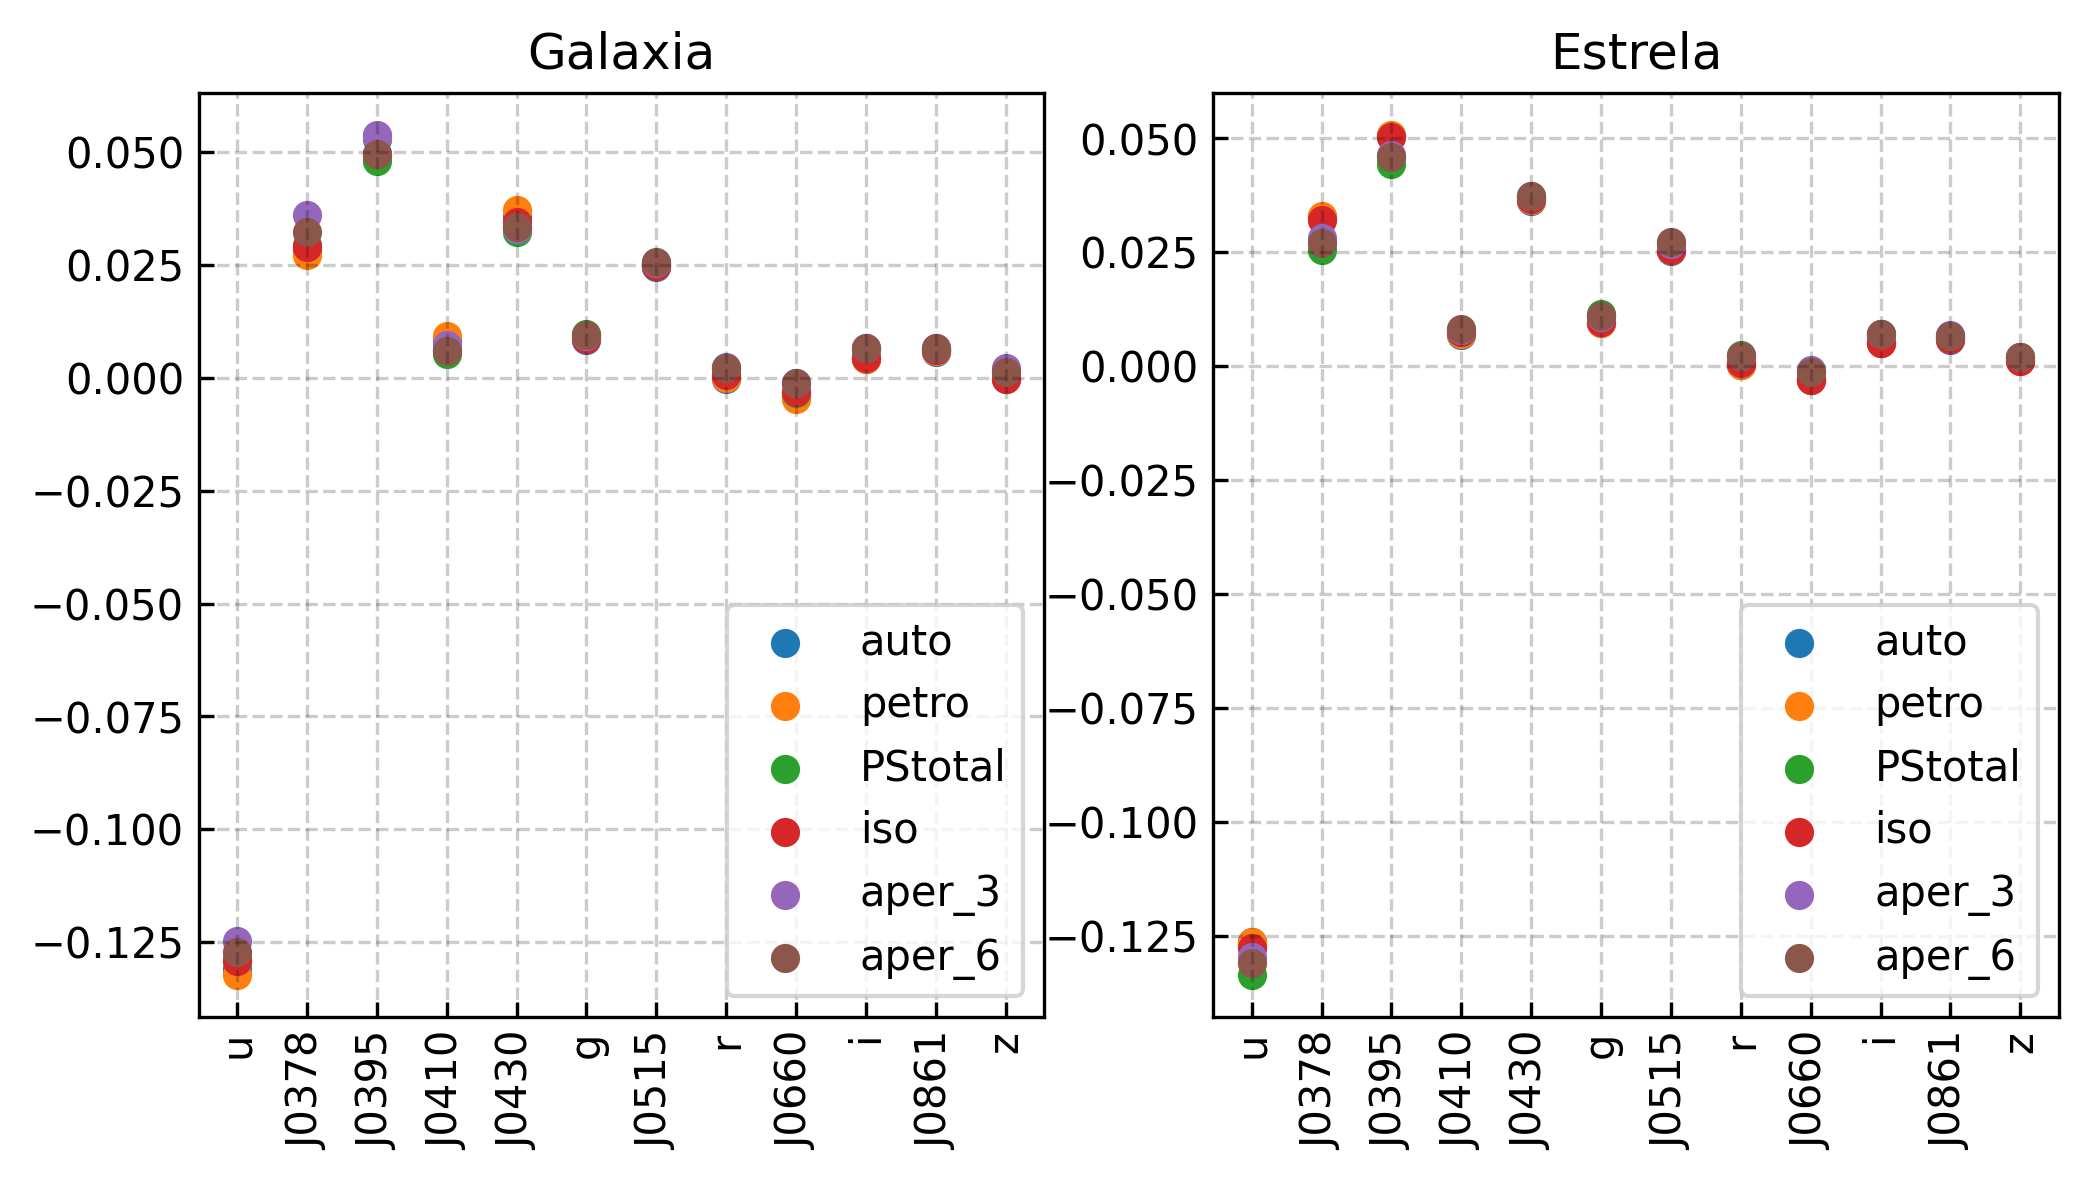

In [119]:
def splus_mag_diff(df: pd.DataFrame, ax: plt.Axes, title: str = None):
  bands = ['u', 'J0378', 'J0395', 'J0410', 'J0430', 'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z']
  for apperture in ['auto', 'petro', 'PStotal', 'iso', 'aper_3', 'aper_6']:
    medians = []
    for band in bands:
      df_clean = df[df[f'{band}_{apperture}_idr4'].between(15, 19)]
      diff = df_clean[f'{band}_{apperture}_idr5'] - df_clean[f'{band}_{apperture}_idr4']
      medians.append(diff.median())
    ax.scatter(range(len(medians)), medians, label=apperture)
  ax.set_title(title)
  ax.grid('on', color='k', linestyle='--', alpha=.2)
  ax.tick_params(direction='in')
  ax.legend()
  ax.set_xticks(range(len(bands)))
  ax.set_xticklabels(bands, rotation=90)

  
fig, axs = plt.subplots(
  nrows=1, 
  ncols=2, 
  figsize=(8, 4), 
  # subplot_kw={'projection': 'scatter_density'}, 
  dpi=300
)
df = df_match[df_match.type != 'PSF']
splus_mag_diff(df, axs[0], 'Galaxia')
df = df_match[df_match.type == 'PSF']
splus_mag_diff(df, axs[1], 'Estrela')

In [112]:
from typing import Literal


def jype_mask(df: pd.DataFrame):
  jype_fields = Path('/mnt/hd/natanael/astrodata/JYPE.txt').open().readlines()
  arr = np.empty(shape=(len(df), len(jype_fields)))
  for i, f in enumerate(jype_fields):
    arr[:, i] = df['ID_idr5'].str.upper().str.contains(f[:-2].upper()).values
  arr = arr.any(axis=1)
  return arr

In [121]:
jmask = jype_mask(df_match)
df_match_jype = df_match[jmask]
df_match_mars = df_match[~jmask]

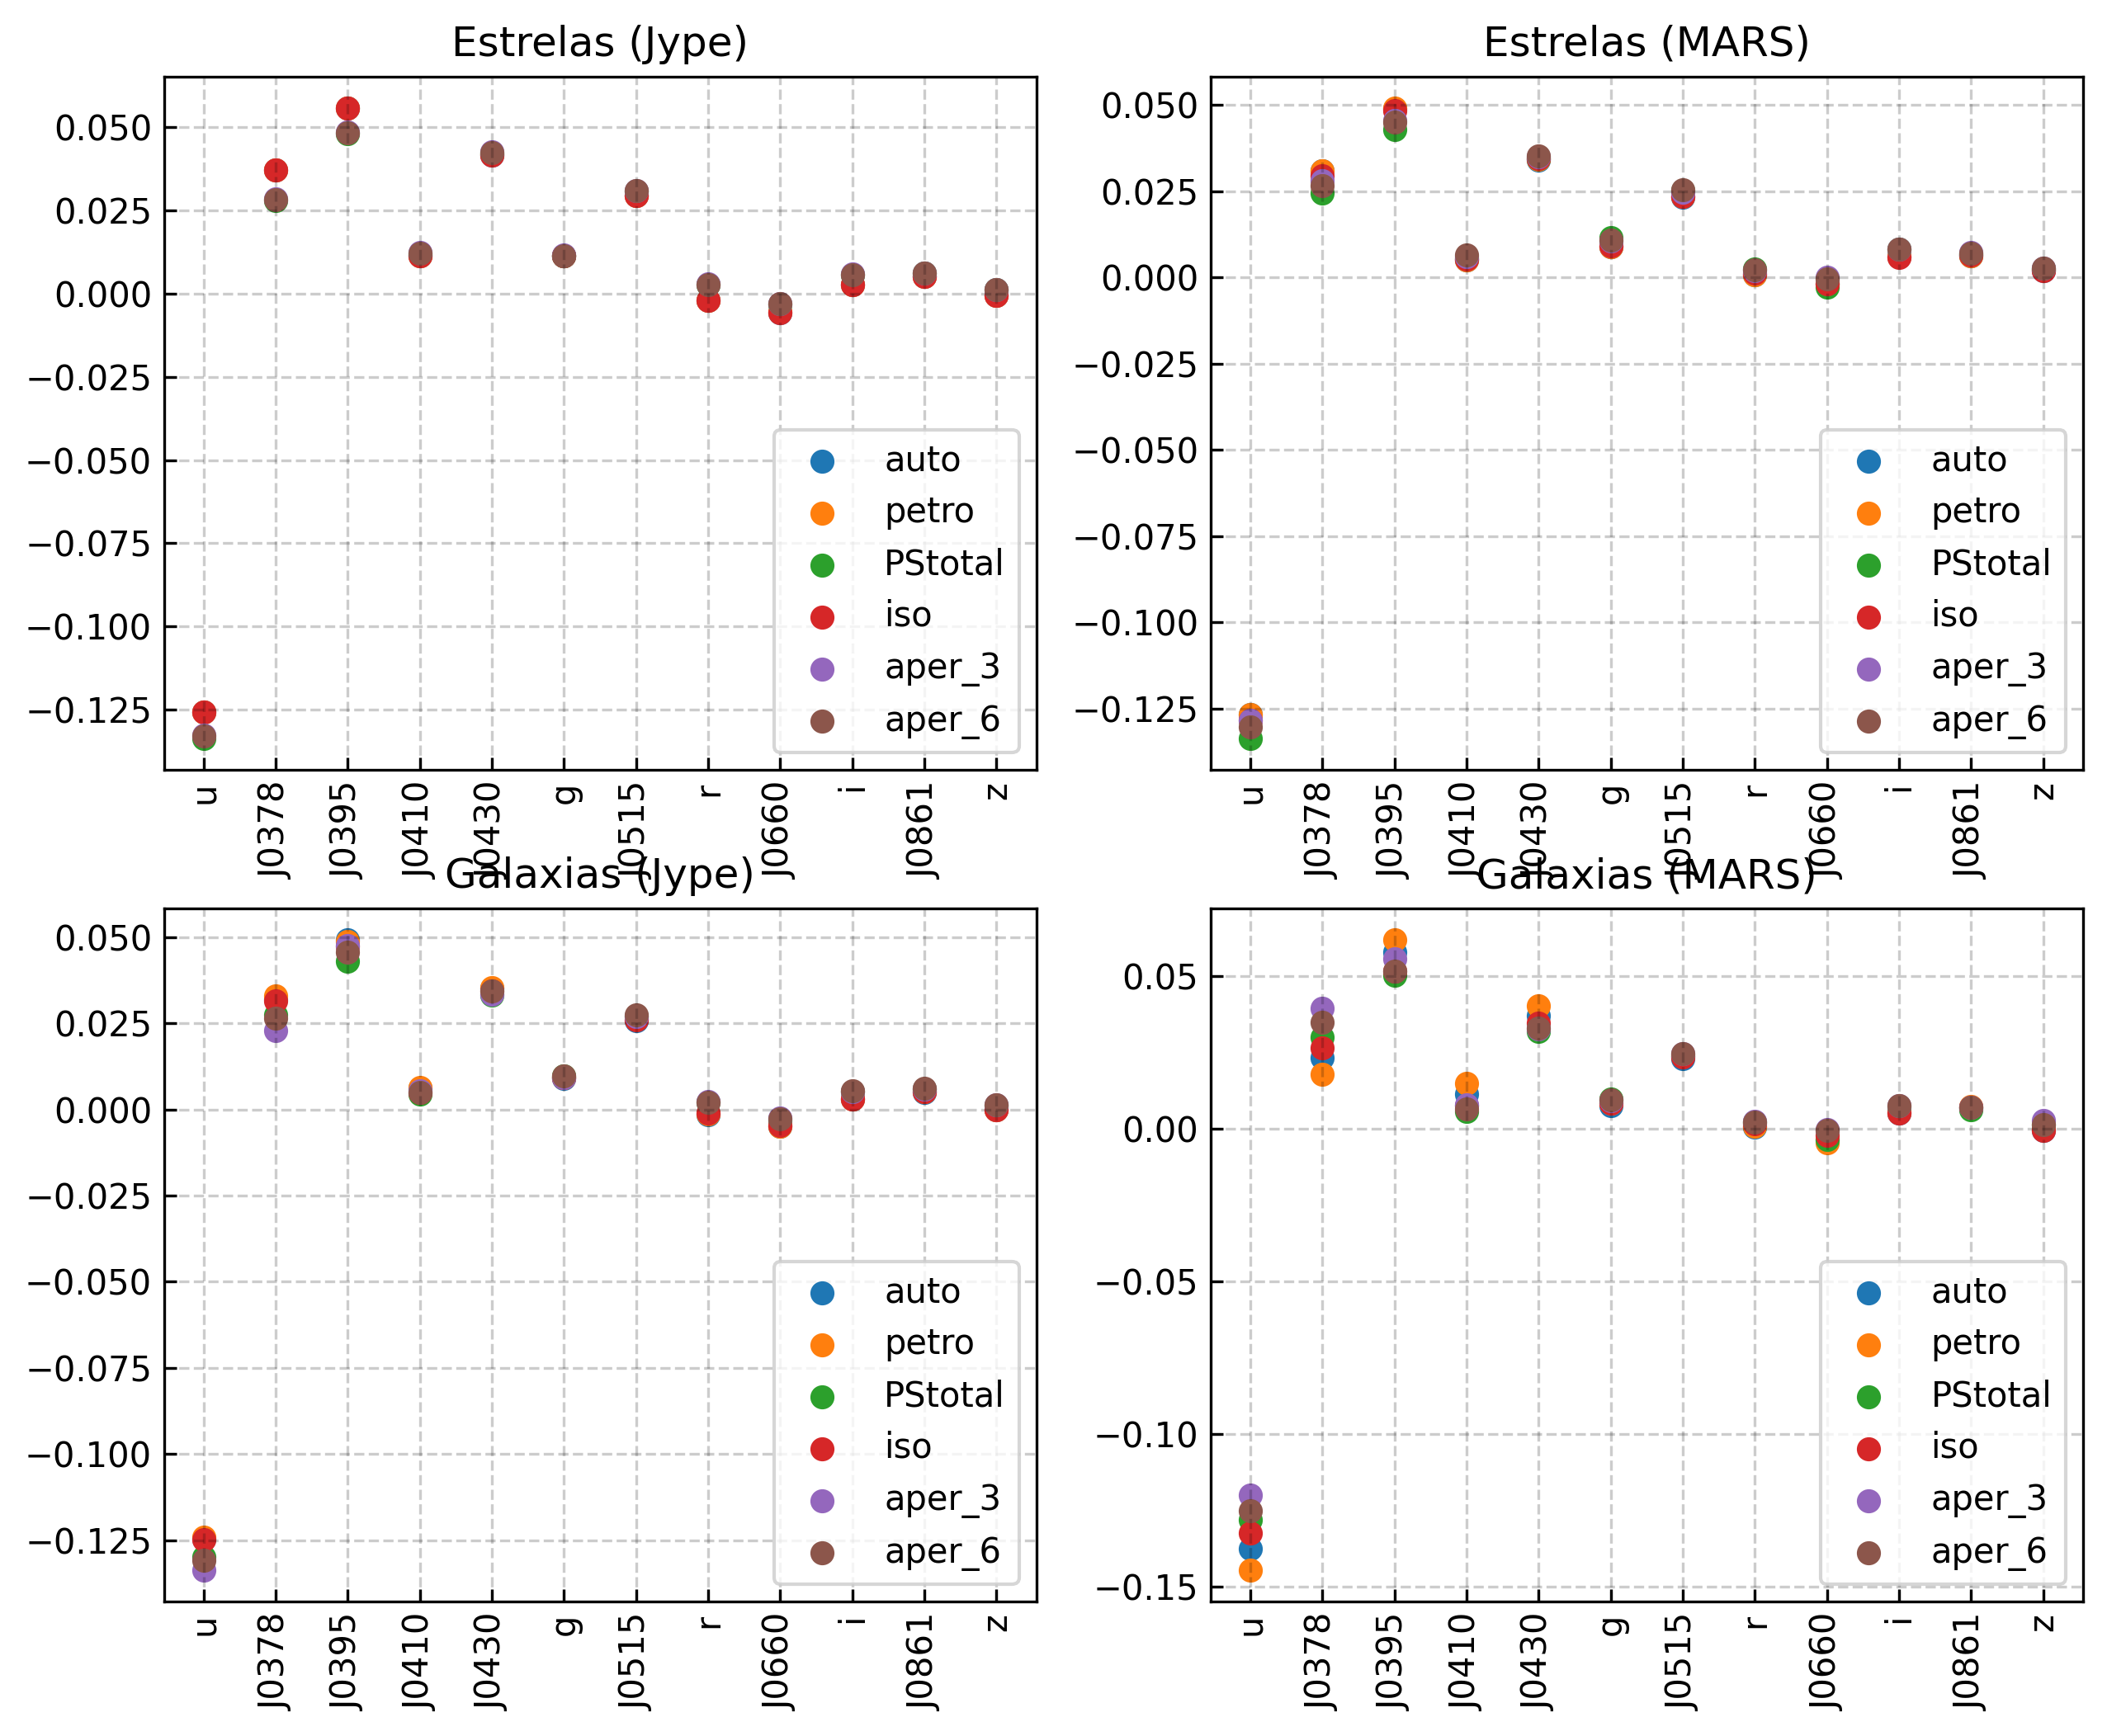

In [122]:
fig, axs = plt.subplots(
  nrows=2, 
  ncols=2, 
  figsize=(10, 8), 
  # subplot_kw={'projection': 'scatter_density'}, 
  dpi=300
)
splus_mag_diff(df_match_jype[df_match_jype.type == 'PSF'], axs[0,0], 'Estrelas (Jype)')
splus_mag_diff(df_match_mars[df_match_mars.type == 'PSF'], axs[0,1], 'Estrelas (MARS)')
splus_mag_diff(df_match_jype[df_match_jype.type != 'PSF'], axs[1,0], 'Galaxias (Jype)')
splus_mag_diff(df_match_mars[df_match_mars.type != 'PSF'], axs[1,1], 'Galaxias (MARS)')
plt.show()

In [93]:
np.count_nonzero(a.any(axis=1))

134229

In [7]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from astromodule.io import read_table
from sklearn.preprocessing import MinMaxScaler

# initialize the data set we'll work with
# training_data, _ = make_classification(
#     n_samples=1000,
#     n_features=2,
#     n_informative=2,
#     n_redundant=0,
#     n_clusters_per_class=1,
#     random_state=4
# )

df = read_table('outputs_v6/photoz+specz+legacy/MKW4.parquet')
training_data = df[['ra', 'dec', 'zml']][~df.zml.isna()].values
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)

# define the model
dbscan_model = DBSCAN(eps=0.25, min_samples=9)

# assign each data point to a cluster
dbscan_result = dbscan_model.fit_predict(training_data)

# get all of the unique clusters
dbscan_clusters = unique(dbscan_result)

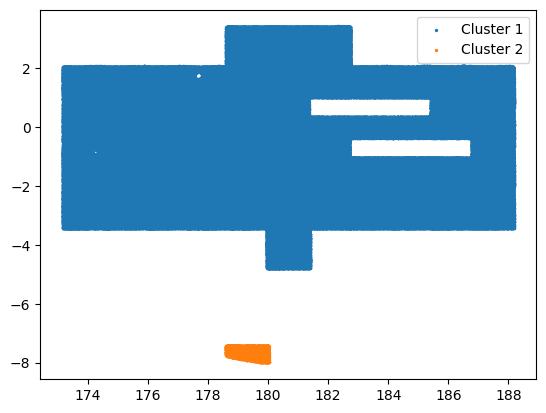

In [9]:
for i, dbscan_cluster in enumerate(dbscan_clusters, 1):
    # get data points that fall in this cluster
    index = where(dbscan_result == dbscan_cluster)
    # make the plot
    pyplot.scatter(training_data[index, 0], training_data[index, 1], s=2, label=f'Cluster {i}')

# show the DBSCAN plot
pyplot.legend()
pyplot.show()